Test notebook


In [2]:
# %%

import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np



In [3]:

''' Format plots'''

fsize = 11
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["yellowgreen", "black", "dimgrey", 'darkgreen', 'aqua', 'deepskyblue', 'orange', 'blue', 'indianred']) 



Import the data from the runs 

In [23]:
# all_strike_prices = np.load(f'C:/Users/LukaK/OneDrive - Durham University/Projects/Agent based modelling easy/PowerSim/data_out/all_strike_prices.npy')
# total_per_tech = np.load(f'C:/Users/LukaK/OneDrive - Durham University/Projects/Agent based modelling easy/PowerSim/data_out/total_per_tech.npy')

import os

directory = 'data/total_per_tech/changing_fuel_price/tech/'

npy_files = [filename for filename in os.listdir(directory) if filename.endswith('.npy')]

# Load the first file to initialize the array


arrays =[]
# stack the remaining files
for filename in npy_files[1:]:
    filepath = os.path.join(directory, filename)
    file_data = np.load(filepath)
    arrays.append(file_data)

total_per_tech = np.stack(arrays, axis =0)
'''[run, year, tech, hour]'''


print(np.shape(total_per_tech))



''' set the number parameters from the run'''
n_days = 36
n_years = 30


descriptor  = 'ippp changing fuel price'
tech_types = ['nuclear', 'coal', 'fossil_fuel', 'bioenergy', 'wind_onshore', 'wind_offshore', 'solar', 'hydro', 'CCGT']


(500, 30, 9, 864)


0.0011891080925906276 0.9788560863166272


change data 

In [24]:

from scipy.stats import norm

x = range(1, n_years+1)
data = np.mean(total_per_tech, axis = 3)  # 10 sets of 100 data points

print(np.shape(data))

# Generate some sample data


# Loop through each of the 5 sets of data
mean_all = []
stdev_all = []
for j in range(data.shape[2]):
    means = []
    stdev = []
    # Loop through each of the 10 sets of data within the current set
    for i in range(data.shape[1]):
        y = data[:, i, j]
        mu, std = norm.fit(y)
        means.append(mu)
        stdev.append(std)
    # Calculate the average parameters and errors for the current set
   
    # Add the average parameters and errors to the list for all sets
    mean_all.append(means)
    stdev_all.append(stdev)

mean_all = np.array(mean_all)
stdev_all = np.array(stdev_all)
# Calculate the average parameters and errors for all sets

# Print the results
print(mean_all)
mean_all.shape

(500, 30, 9)
(5, 10, 100)
[[6.17872366e+03 6.17872366e+03 6.17872366e+03 6.17872366e+03
  6.17872366e+03 6.17872366e+03 6.17872366e+03 6.17801718e+03
  6.17314797e+03 6.15827021e+03 6.13450483e+03 6.09903216e+03
  6.05796393e+03 6.74979547e+03 7.49993207e+03 8.23156660e+03
  8.93298693e+03 9.67487012e+03 1.04588767e+04 1.11217485e+04
  1.14863217e+04 1.14736186e+04 1.14739430e+04 1.14859744e+04
  1.14923625e+04 1.07623549e+04 1.07668745e+04 1.07770406e+04
  1.07944918e+04 1.08527159e+04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.16929582e-03 2.34985559e-01 8.49874272e+00
  9.79436478e+00 1.18339527e+01]
 [4.23124925e+00 3.72133926e+00 3.574146

(9, 30)

Make the graphs

(3, 30, 9, 96)
(9, 96)


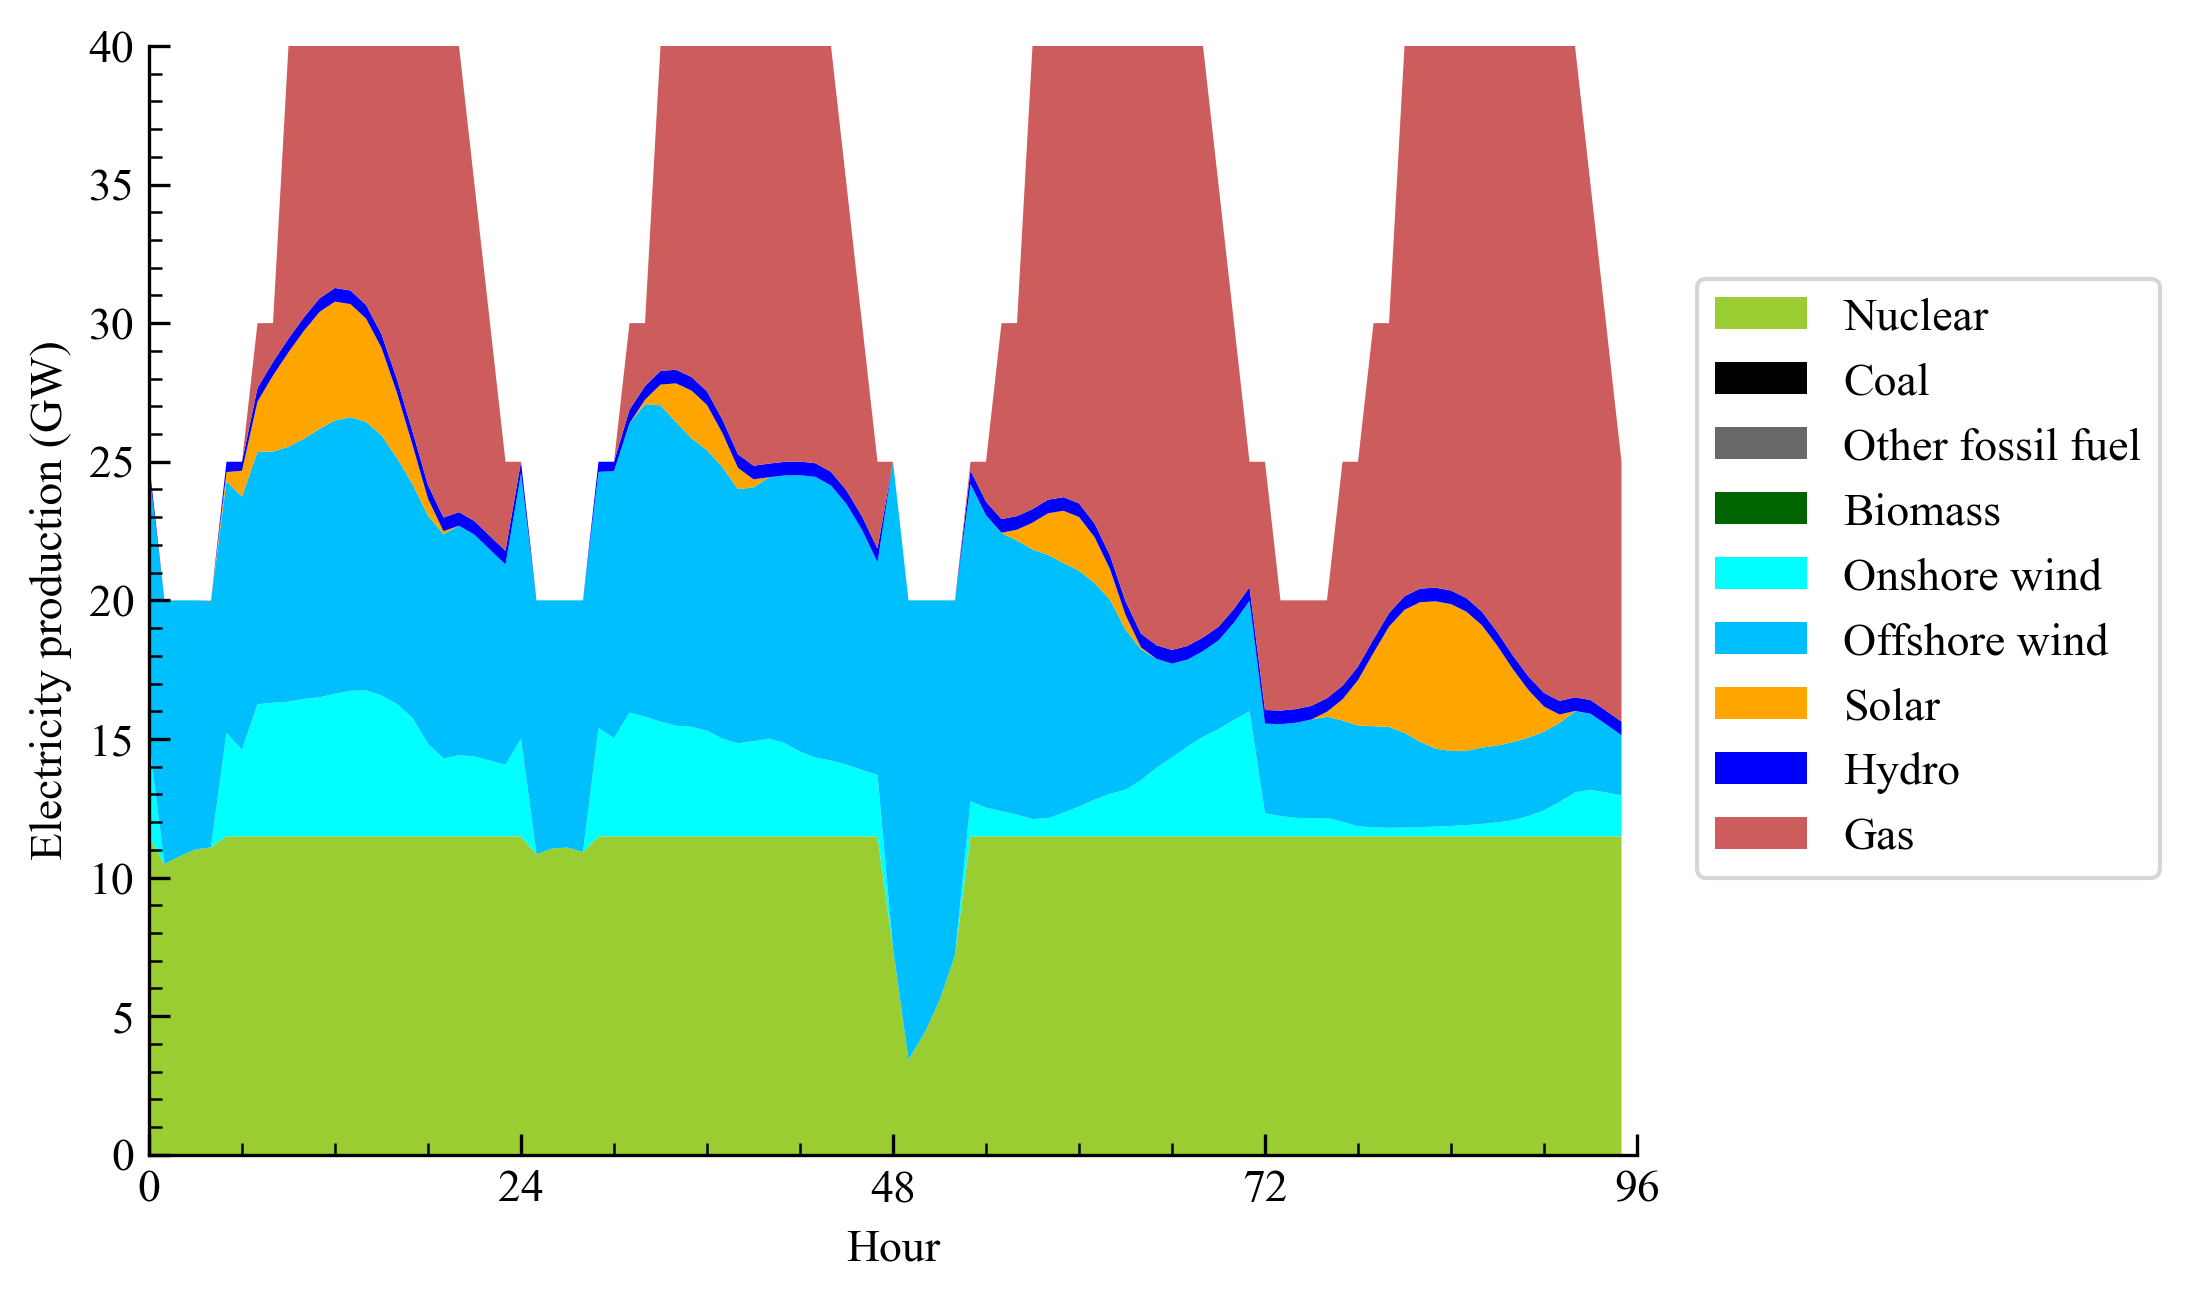

In [17]:


#%%
'''Stacked plot of daily production'''

fig, ax = plt.subplots()


print(np.shape(total_per_tech))



ydata = total_per_tech[0,29,:,:]/1000

print(np.shape(ydata))

xdata = range((n_days*24))

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["yellowgreen", "black", "dimgrey", 'darkgreen', 'aqua', 'deepskyblue', 'orange', 'blue', 'indianred']) 

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']
ax.stackplot(xdata,*ydata, labels = [t for t in tech_types_named])
#have to remove the historical data from the plot



ax.set_ylabel('Electricity production (GW)')
ax.set_xlabel('Hour')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xlim(0, len(xdata))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(fname = f'{descriptor}year production by day', bbox_inches = "tight" )
plt.show()



(30, 9)


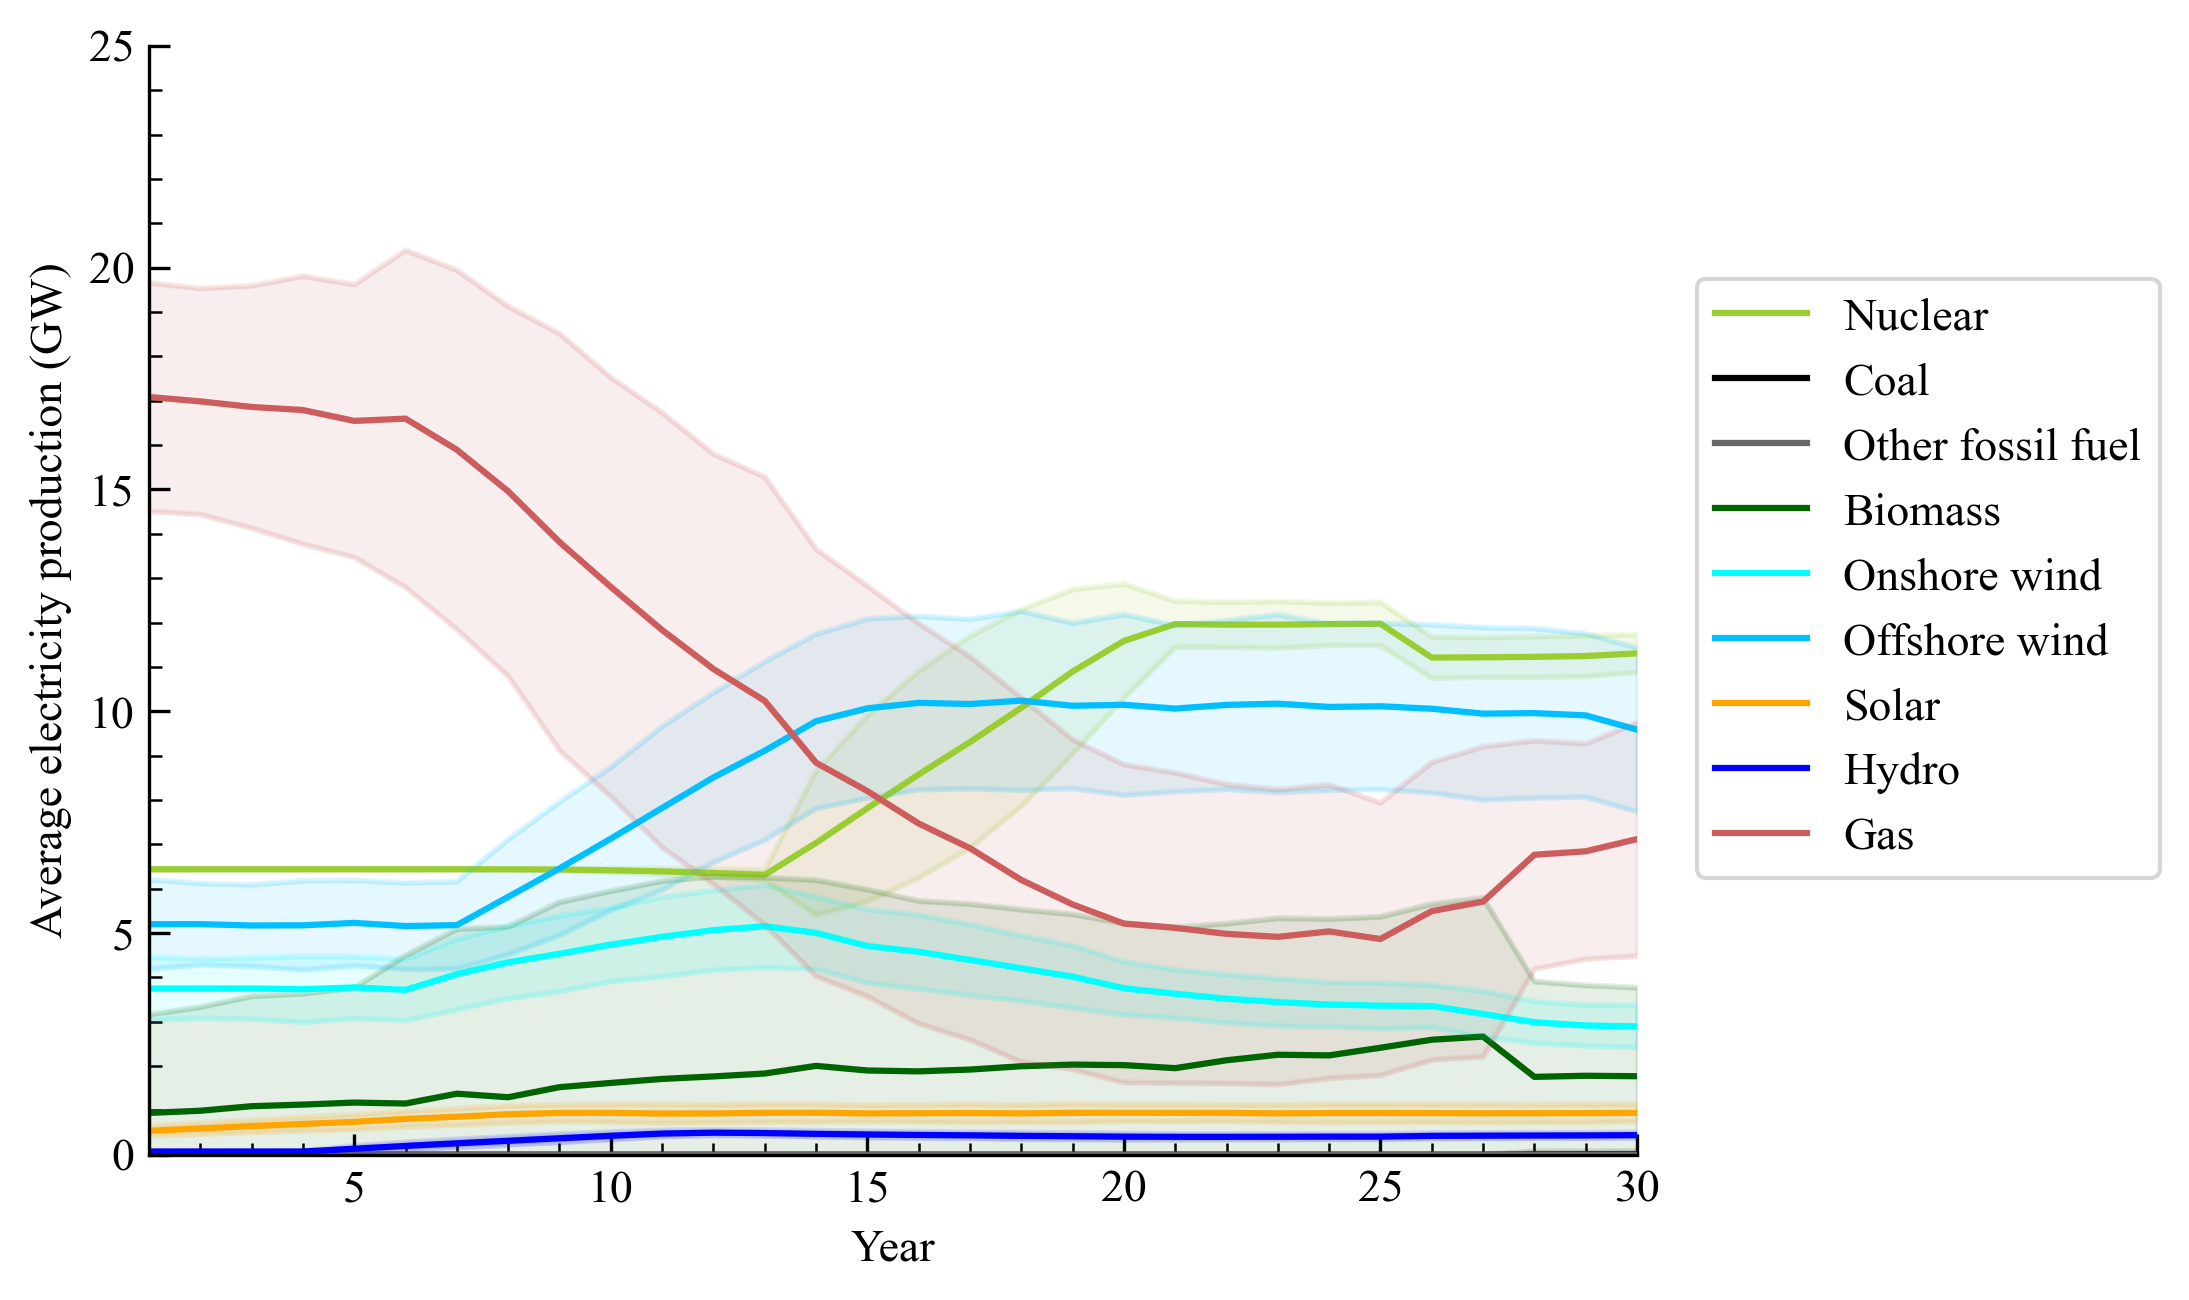

In [26]:


fig, ax = plt.subplots()

total_per_tech_average= np.mean(total_per_tech, axis=3)

ydata = np.mean(total_per_tech_average, axis = 0)
print(np.shape(ydata))
xdata = range(1, n_years+1)

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']
colours = ["yellowgreen", "black", "dimgrey", 'darkgreen', 'aqua', 'deepskyblue', 'orange', 'blue', 'indianred']
for i in range(9):
    y = ydata[:,i]/(960)
    ax.plot(xdata,y, label =  tech_types_named[i], color = colours[i])
    ax.plot(xdata, (mean_all[i,:] + 2*stdev_all[i, :])/960, color = colours[i], alpha = 0.1)
    ax.plot(xdata, (mean_all[i,:] - 2*stdev_all[i, :])/960, color = colours[i], alpha = 0.1)
    ax.fill_between(xdata, (mean_all[i,:] + 2*stdev_all[i, :])/960, (mean_all[i,:] - 2*stdev_all[i, :])/960,color = colours[i], alpha = 0.1)
#have to remove the historical data from the plot

ax.set_ylabel('Average electricity production (GW)')
ax.set_xlabel('Year')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlim(1, max(xdata))
ax.set_ylim(0)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(fname = f'{descriptor}average_production yearly', bbox_inches = "tight" )
plt.show()




In [52]:

'''Get average yearly prices'''

directory = 'data/total_per_tech/36days/price/'

npy_files = [filename for filename in os.listdir(directory) if filename.endswith('.npy')]

# Load the first file to initialize the array


arrays =[]
# stack the remaining files
for filename in npy_files[1:]:
    filepath = os.path.join(directory, filename)
    file_data = np.load(filepath)
    arrays.append(file_data)

yearly_price = np.stack(arrays, axis =0)
'''[run, year, tech, hour]'''

descriptor = 'no changing price av'

In [55]:
n_days = 36
n_runs = 499
print(np.shape(yearly_price))



average_daily_p = np.mean(yearly_price, axis = 2)

av_daily_2d = average_daily_p.reshape(n_runs,n_years,n_days)
print(np.shape(av_daily_2d))

mean_yearly = np.mean(av_daily_2d, axis = 2)





x = range(1, n_years+1)
data = mean_yearly  # 10 sets of 100 data points

print(np.shape(data))

# Generate some sample data


# Loop through each of the 5 sets of data
mean_all_price = []
stdev_all_price = []

for i in range(data.shape[1]):
    y = data[:, i]
    mu, std = norm.fit(y)
    mean_all_price.append(mu)
    stdev_all_price.append(std)
# Calculate the average parameters and errors for the current set

# Add the average parameters and errors to the list for all sets


mean_all_price = np.array(mean_all_price)
stdev_all_price = np.array(stdev_all_price)
# Calculate the average parameters and errors for all sets

# Print the results
print(mean_all_price)
print(stdev_all_price)
mean_all.shape


(499, 1080, 24)
(499, 30, 36)
(499, 30)
[71.63908288 71.43720404 71.36197065 71.2283893  70.93151976 68.15806612
 67.40007048 66.18221441 64.81701376 63.55347167 61.76986177 59.95162168
 57.90320784 54.9763331  53.03924615 51.82630206 50.46046021 49.30924136
 48.13286136 46.96314403 46.12964465 46.39070388 46.97982116 47.42038835
 47.67517307 50.01050653 50.46117985 52.44013828 52.72658344 53.75792054]
[1.56449985 1.52985744 1.5459171  1.55936466 1.40492339 1.02556482
 0.98742353 1.26699025 1.48280912 1.68320996 2.13607965 2.39341064
 2.59188165 3.30045314 3.58888549 3.88540336 4.02788122 3.87760284
 3.87039319 3.47635393 3.23231153 3.23270746 3.29442057 3.17749984
 3.20342566 3.12657732 3.10183167 3.15108425 3.05244095 3.23204403]


(9, 30)

No handles with labels found to put in legend.


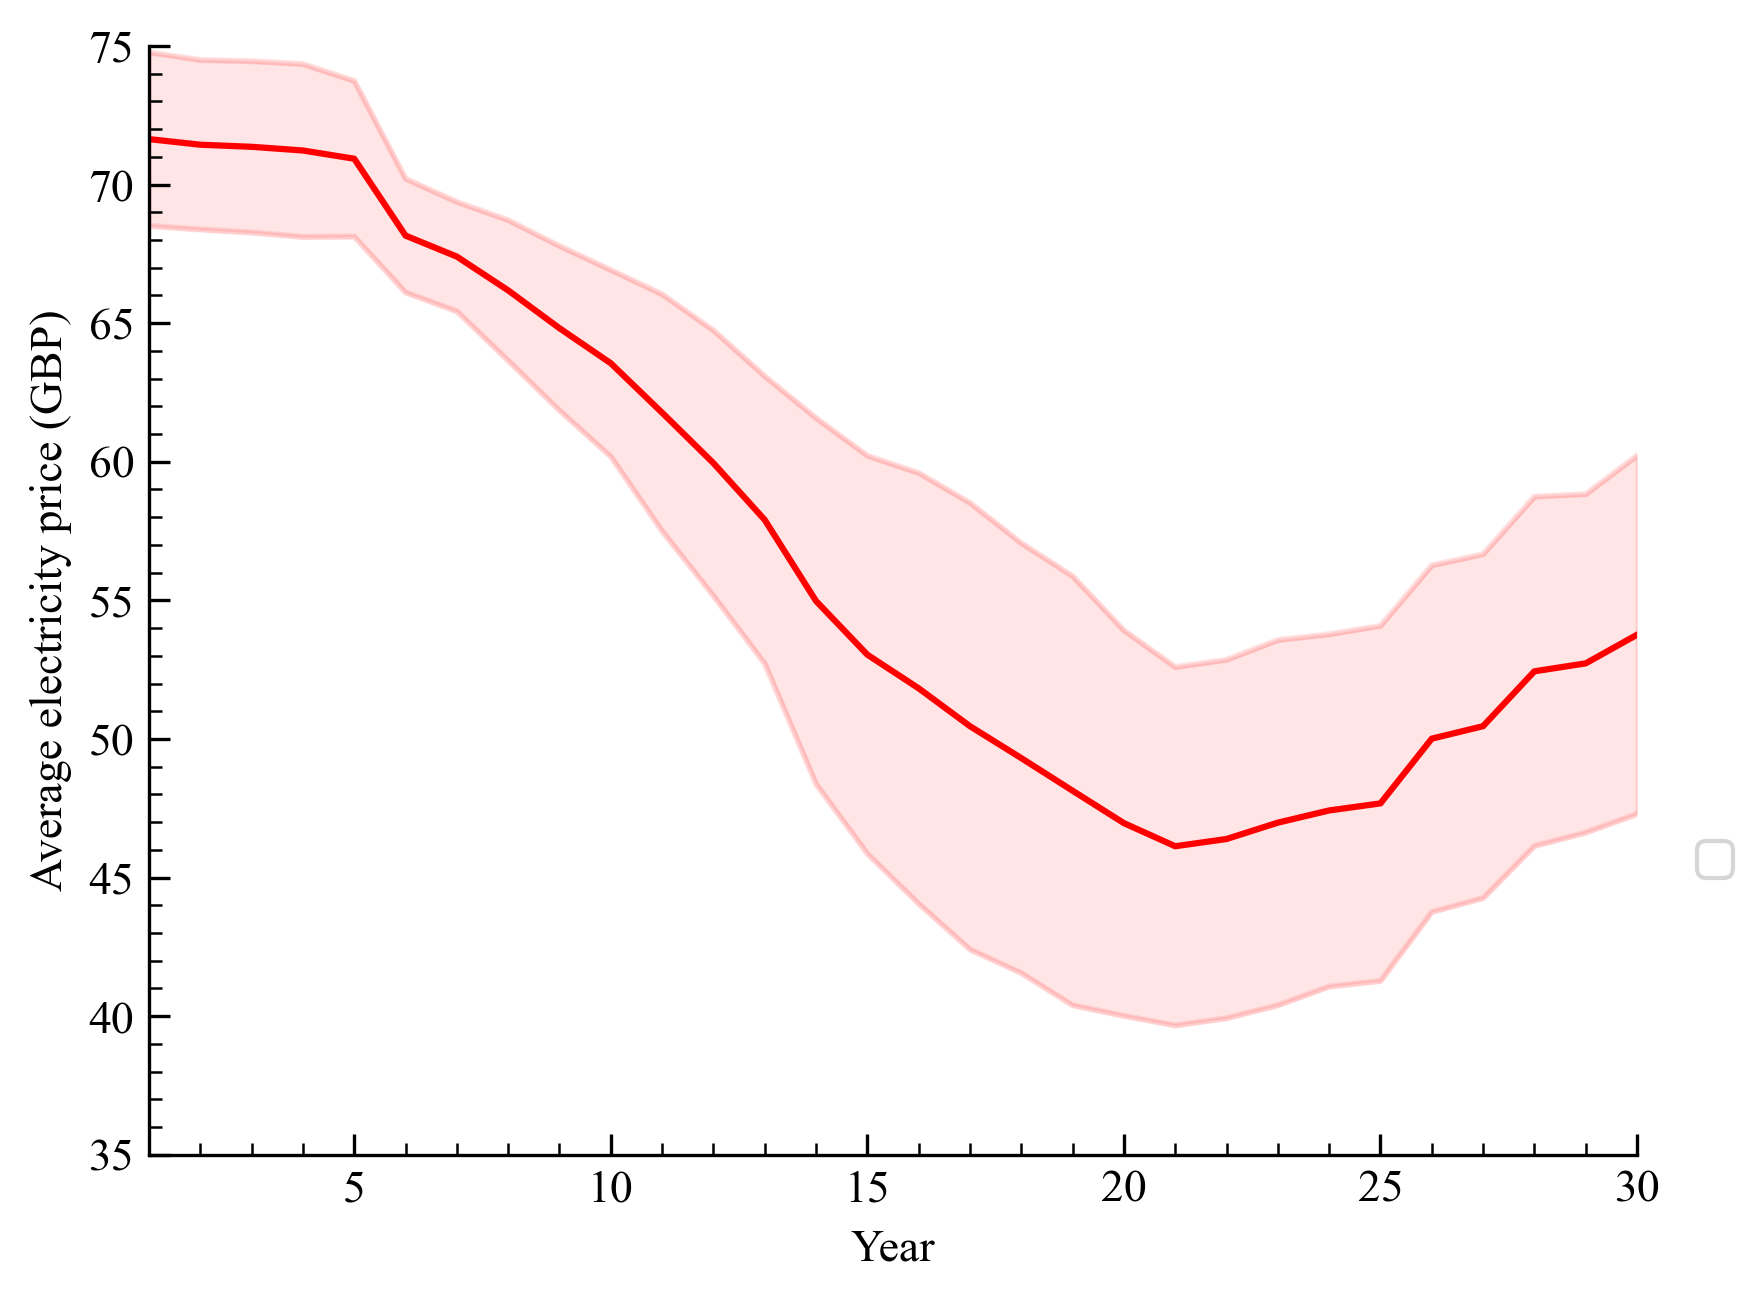

In [56]:

fig, ax = plt.subplots()



ydata = mean_all_price

xdata = range(1, n_years+1)

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']

ax.plot(xdata,ydata, color = 'r')
ax.plot(xdata, ydata + 2*stdev_all_price, color = 'r', alpha = 0.1)
ax.plot(xdata, ydata - 2*stdev_all_price, color = 'r', alpha = 0.1)
ax.fill_between(xdata, ydata + 2*stdev_all_price, ydata - 2*stdev_all_price, color ='r', alpha = 0.1 )
#have to remove the historical data from the plot

ax.set_ylabel('Average electricity price (GBP)')
ax.set_xlabel('Year')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlim(1, max(xdata))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(fname = f'{descriptor}av. price.png', bbox_inches = "tight" )
plt.show()


In [41]:
import electricity_company
import pickle

with open('powerplants.pickle', 'rb') as f:
    obj_list_new = pickle.load(f)


In [57]:


tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']

for obj in obj_list_new: 
    if obj.name == 'RWE Npower':
        elec_co = obj

plant_list_npower = elec_co.power_plants

for plant in plant_list:
    print(plant.capacity_MW)

        for tech in tech_types:
        energy = [(plant.energy_supplied_per_hour[-(24*world.n_days):]) for plant in plant_list if plant.technology == tech and len(plant.energy_supplied_per_hour) >= 24]
        energy = np.sum(energy, axis = 0)
        y_total_per_tech.append(energy)

0.505
0.505
0.56
0.6
0.75
0.78
0.85
0.95
1.35
2.0
2.0
2.274
2.3
2.3
2.3
2.4
2.5
2.6
2.75
2.75
2.969
3.0
3.0
3.5
3.9
4.0
4.1
4.1
5.0
5.15
5.15
5.5
6.0
6.0
6.0
6.6
9.0
9.1
9.2
9.4
9.4
9.6
9.9
14.0
14.98
15.6
15.6
15.8
16.0
17.0
17.0
19.3
20.0
20.0
20.5
24.7
26.65
32.8
33.0
34.85
36.8
40.0
44.0
44.0
50.0
54.0
55.0
57.4
59.8
60.0
60.0
65.0
84.0
90.0
90.0
96.0
100.0
140.0
219.0
352.8
395.0
400.2
420.0
576.0
630.0
723.0
857.0
1450.0
1772.0
2199.0
5.39904
1.21275
7.63
5.41057
4.857
18.73872
0.054
9.6
9.9
1.51164
2.9
119.8
0.958
0.8064
94.05
20.5
4.6
7.2
